Лабораторная работа №4

Случайный лес

In [194]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay,  mean_absolute_error

Классификация (стандартный бейзлайн)

Датасет для классификации - Spotify Tracks Dataset

Цель данной работы - определение того, будет ли трек популярным (за популярность будем считать показатель popularity выше или равный 70).

В качестве метрик качества будут выступать:

1. Accuracy - доля правильных классификаций.

2. Precision - точность (True_positive / True_positive + False_positive). Минимизирует ложно положительные результаты.

3. Recall - полнота (True_positive / True_positive + False_negative). Минимизирует ложно отрицательные результаты.

4. F1 - взвешенное среднее Precision и Recall.

Импортирование датасета из файла (https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset)

In [195]:
tracks = pd.read_csv('dataset.csv', index_col = 0)
tracks.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


Размер датасета

In [196]:
tracks.shape

(114000, 20)

Информация о типах данных

In [197]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           114000 

Очевидно, что id не влияет на популярность, удалим.

In [198]:
tracks = tracks.drop(['track_id'], axis = 1)

Проведем label encoding текстовых полей artists, album_name, track_name, track_genre

In [199]:
artists = tracks['artists']
album_name = tracks['album_name']
track_name = tracks['track_name']
track_genre = tracks['track_genre']

label_encoder = LabelEncoder()
encoded_artists = label_encoder.fit_transform(artists)
encoded_album_name = label_encoder.fit_transform(album_name)
encoded_track_name = label_encoder.fit_transform(track_name)
encoded_track_genre = label_encoder.fit_transform(track_genre)

tracks['artists'] = encoded_artists
tracks['album_name'] = encoded_album_name
tracks['track_name'] = encoded_track_name
tracks['track_genre'] = encoded_track_genre

tracks.head()

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,10357,8100,11741,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,0
1,3287,14796,22528,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,0
2,12397,39162,60774,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,0
3,14839,8580,9580,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,0
4,5255,16899,25689,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,0


Введем новое поле is_popular, зависящее от popularity, для более простой оценки популярности.

In [200]:
popularity_rate = 70.0

tracks['is_popular'] = np.select([(tracks['popularity'] >= popularity_rate), (tracks['popularity'] < popularity_rate)], [1, 0])
tracks.head()

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,is_popular
0,10357,8100,11741,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,0,1
1,3287,14796,22528,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,0,0
2,12397,39162,60774,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,0,0
3,14839,8580,9580,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,0,1
4,5255,16899,25689,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,0,1


Разделим датасет на train и test.

При этом поля is_popular и popularity удалим из входных данных, а выходными будет поле is_popular.

In [202]:
y_classifier = tracks['is_popular']
X_classifier = tracks.drop(["is_popular", "popularity"], axis = "columns")

simpleimputer = SimpleImputer(strategy='mean')
X_classifier = pd.DataFrame(simpleimputer.fit_transform(X_classifier))

X_train_classifier, X_test_classifier, y_train_classifier, y_test_classifier = train_test_split(X_classifier, y_classifier, test_size = 0.1, random_state = 228, shuffle = True)

Обучение модели и вывод метрик.

In [203]:
rf_classifier = RandomForestClassifier(random_state=228)
rf_model_classifier = rf_classifier.fit(X_train_classifier, y_train_classifier)

rf_predictions_classifier = rf_classifier.predict(X_test_classifier)

accuracy = accuracy_score(y_test_classifier, rf_predictions_classifier)
f1 = f1_score(y_test_classifier, rf_predictions_classifier)
precision = precision_score(y_test_classifier, rf_predictions_classifier)
recall = recall_score(y_test_classifier, rf_predictions_classifier)

print(f"accuracy: {accuracy}")
print(f"f1: {f1}")
print(f"precision: {precision}")
print(f"recall: {recall}")

accuracy: 0.9746491228070175
f1: 0.6538922155688622
precision: 0.9479166666666666
recall: 0.4990859232175503


Матрица ошибок

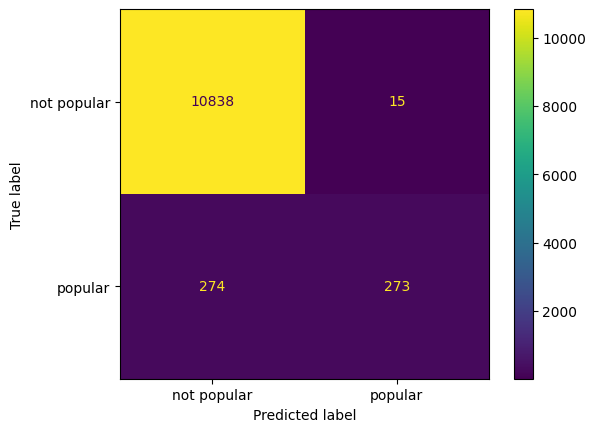

In [204]:
cm = confusion_matrix(y_test_classifier, rf_predictions_classifier)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks([0, 1], ['not popular', 'popular'])
plt.yticks([0, 1], ['not popular', 'popular'])
plt.show()

Регрессия (стандартный бейзлайн)

Датасет для регрессии - IGN Games

Цель данной работы - предугадать оценку игры на IGN по её параметрам.

В качестве метрики качества будут выступать Mean Absolute Error - средняя абсолютная ошибка.

Импортирование датасета из файла (https://www.kaggle.com/datasets/joebeachcapital/ign-games)

In [173]:
games = pd.read_csv('ign.csv', index_col = 0)
games.head()

,score_phrase,title,url,platform,score,genre,editors_choice,release_year,release_month,release_day
0,Amazing,LittleBigPlanet PS Vita,/games/littlebigplanet-vita/vita-98907,PlayStation Vita,9.0,Platformer,Y,2012,9,12
1,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,/games/littlebigplanet-ps-vita-marvel-super-he...,PlayStation Vita,9.0,Platformer,Y,2012,9,12
2,Great,Splice: Tree of Life,/games/splice/ipad-141070,iPad,8.5,Puzzle,N,2012,9,12
3,Great,NHL 13,/games/nhl-13/xbox-360-128182,Xbox 360,8.5,Sports,N,2012,9,11
4,Great,NHL 13,/games/nhl-13/ps3-128181,PlayStation 3,8.5,Sports,N,2012,9,11


Размер датасета

In [116]:
games.shape

(18625, 10)

Информация о типах данных

In [174]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18625 entries, 0 to 18624
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   score_phrase    18625 non-null  object 
 1   title           18625 non-null  object 
 2   url             18625 non-null  object 
 3   platform        18625 non-null  object 
 4   score           18625 non-null  float64
 5   genre           18589 non-null  object 
 6   editors_choice  18625 non-null  object 
 7   release_year    18625 non-null  int64  
 8   release_month   18625 non-null  int64  
 9   release_day     18625 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 1.6+ MB


Удалим столбец score_phrase, так как он является текстовым алиасом столбца score.



In [175]:
games = games.drop(['score_phrase'], axis = 1)

Проведем label encoding текстовых полей

In [176]:
title = games['title']
url = games['url']
platform = games['platform']
genre = games['genre']
editors_choice = games['editors_choice']

label_encoder = LabelEncoder()
encoded_title = label_encoder.fit_transform(title)
encoded_url = label_encoder.fit_transform(url)
encoded_platform = label_encoder.fit_transform(platform)
encoded_genre = label_encoder.fit_transform(genre)
encoded_editors_choice = label_encoder.fit_transform(editors_choice)


games['title'] = encoded_title
games['url'] = encoded_url
games['platform'] = encoded_platform
games['genre'] = encoded_genre
games['editors_choice'] = encoded_editors_choice

games.head()

,title,url,platform,score,genre,editors_choice,release_year,release_month,release_day
0,5684,8389,35,9.0,63,1,2012,9,12
1,5685,8386,35,9.0,63,1,2012,9,12
2,9764,14318,56,8.5,68,0,2012,9,12
3,7050,10812,54,8.5,93,0,2012,9,11
4,7050,10811,32,8.5,93,0,2012,9,11


Разделим датасет на train и test

In [177]:
y_regression = games['score']
X_regression = games.drop(['score'], axis = "columns")

simpleimputer = SimpleImputer(strategy='mean')
X_regression = pd.DataFrame(simpleimputer.fit_transform(X_regression))

X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X_regression, y_regression, test_size = 0.1, random_state = 228, shuffle = True)

Обучение модели и вывод метрик

In [178]:
rf_regression = RandomForestRegressor(random_state=228)
rf_model_regression = rf_regression.fit(X_train_regression, y_train_regression)

rf_predictions_regression = rf_regression.predict(X_test_regression)

mae = mean_absolute_error(y_test_regression, rf_predictions_regression)
print(f"MAE: {mae}")

MAE: 1.0094186795491145


Также оценим небольшую выборку из первых 100 игр, сравним значения модели и реальные оценки на графике.

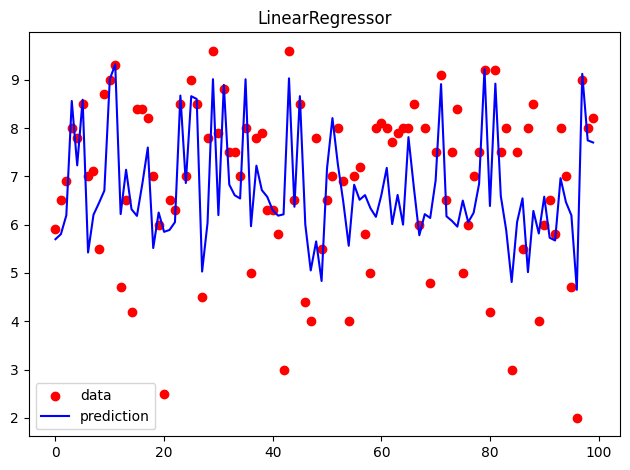

In [179]:
count = 100

plt.scatter(np.arange(0, len(y_test_regression))[0:count], list(y_test_regression)[0:count], color="red", label="data")
plt.plot(np.arange(0, len(y_test_regression))[0:count], rf_predictions_regression[0:count], color="blue", label="prediction")
plt.axis("tight")
plt.legend()
plt.title("LinearRegressor")

plt.tight_layout()
plt.show()

Классификация (улучшенный бейзлайн)

Гипотезы:

1) если убрать artists, album_name, track_name, то обучение будет идти лучше (эти параметры нормально не могут быть представлены в числовом виде, и скорее всего создают шум)

2) можно убрать кореллирующие данные (чтобы они не усиливали друг друга и не давали отклонения)

3) можно убрать нулевые данные, повторяющиеся (непонятно что делать с такими данными, лучше от них избавиться)

4) воспользуемся Grid Search с кросс-валидацией для оптимизации модели.

В этот раз не будем делать one-hot, ибо в тот раз оно показало себя хуже



In [127]:
opt_tracks = tracks
opt_tracks = opt_tracks.drop(['artists'], axis = 1)
opt_tracks = opt_tracks.drop(['album_name'], axis = 1)
opt_tracks = opt_tracks.drop(['track_name'], axis = 1)
opt_tracks.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,is_popular
0,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,0,1
1,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,0,0
2,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,0,0
3,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,0,1
4,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,0,1


Построим матрицу корреляции для удаления коррелирующих значений.

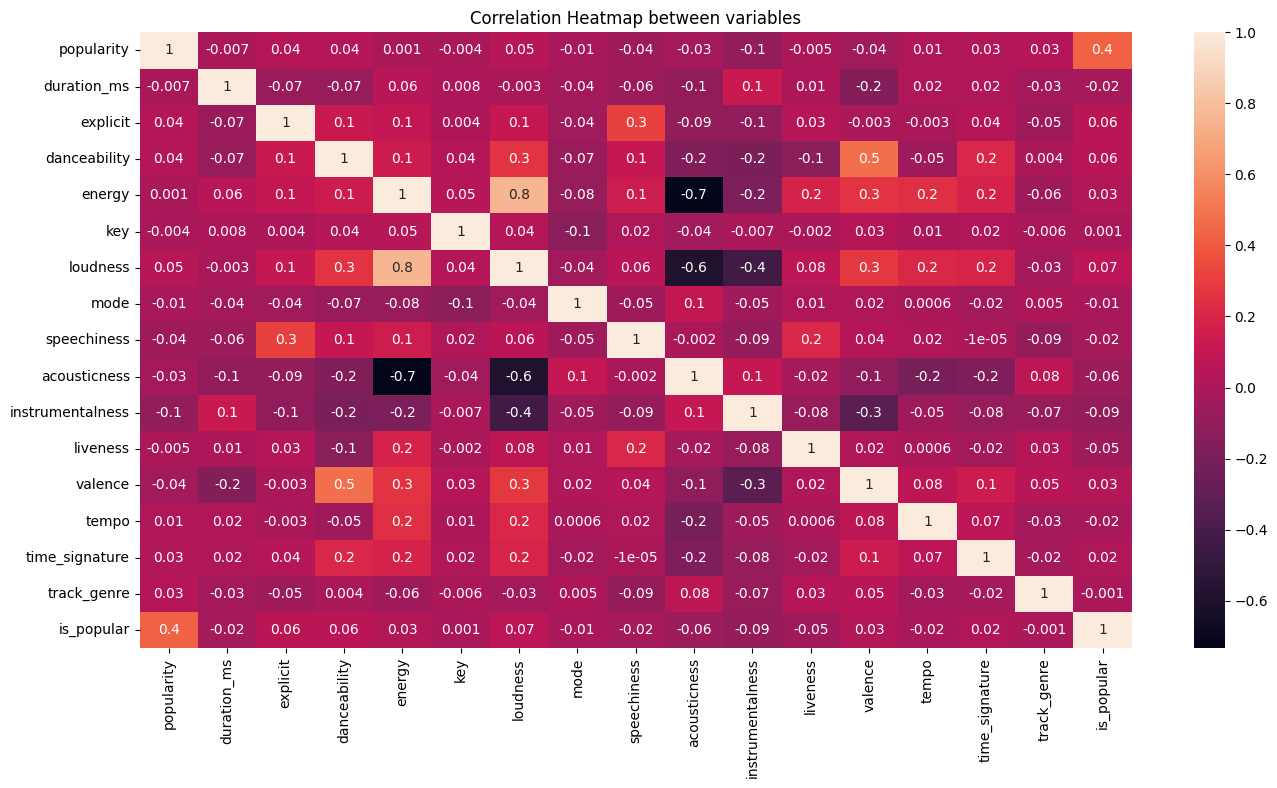

In [128]:
import seaborn as sns

corr_table = opt_tracks.corr(method = "pearson")

plt.figure(figsize=(16,8))
sns.heatmap(corr_table, annot=True, fmt=".1g")
plt.title("Correlation Heatmap between variables")
plt.show()

Больше всего кореллирует energy, уберем

In [129]:
opt_tracks = opt_tracks.drop(["energy"], axis = 1)

Разделим датасет и проведем кросс-валидацию (теперь оптимизация идет по recall)


In [137]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

opt_y_classifier = opt_tracks['is_popular']
opt_X_classifier = opt_tracks.drop(["is_popular", "popularity"], axis = "columns")

simpleimputer = SimpleImputer(strategy='mean')
opt_X_classifier = pd.DataFrame(simpleimputer.fit_transform(opt_X_classifier))

opt_X_train_classifier, opt_X_test_classifier, opt_y_train_classifier, opt_y_test_classifier = train_test_split(opt_X_classifier, opt_y_classifier, test_size = 0.1, random_state = 228, shuffle = True)


opt_X_train_classifier = scaler.fit_transform(opt_X_train_classifier)
opt_X_test_classifier = scaler.fit_transform(opt_X_test_classifier)

param_grid = {
    'n_estimators': [1, 10, 50],
    'max_depth': [5, 10, None],
    'min_samples_split': [5, 10, 15],
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=228), param_grid, cv=5, scoring='recall')
grid_search.fit(opt_X_train_classifier, opt_y_train_classifier)

print("Лучшие параметры: ", grid_search.best_params_)

Лучшие параметры:  {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 1}


Обучение и вывод метрик (также применим масштабирование данных)



accuracy: 0.9317543859649123
f1: 0.240234375
precision: 0.2578616352201258
recall: 0.22486288848263253


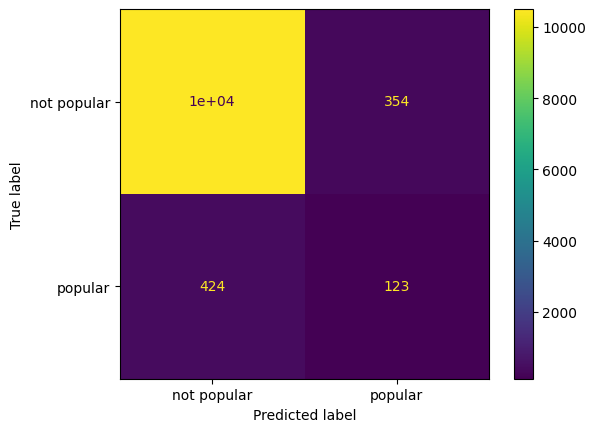

In [138]:
opt_rf_classifier = RandomForestClassifier(random_state=228, max_depth=None, min_samples_split=5, n_estimators=1)
opt_rf_model_classifier = opt_rf_classifier.fit(opt_X_train_classifier, opt_y_train_classifier)

opt_rf_predictions_classifier = opt_rf_classifier.predict(opt_X_test_classifier)

accuracy = accuracy_score(opt_y_test_classifier, opt_rf_predictions_classifier)
f1 = f1_score(opt_y_test_classifier, opt_rf_predictions_classifier)
precision = precision_score(opt_y_test_classifier, opt_rf_predictions_classifier)
recall = recall_score(opt_y_test_classifier, opt_rf_predictions_classifier)

print(f"accuracy: {accuracy}")
print(f"f1: {f1}")
print(f"precision: {precision}")
print(f"recall: {recall}")

cm = confusion_matrix(opt_y_test_classifier, opt_rf_predictions_classifier)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks([0, 1], ['not popular', 'popular'])
plt.yticks([0, 1], ['not popular', 'popular'])
plt.show()

Регрессия (улучшенный бейзлайн)

Гипотезы:

1) title и url, скорее всего, не играют никакой роли, к тому же численно не представимы.

2) можно убрать кореллирующие данные (чтобы они не усиливали друг друга и не давали отклонения)

3) можно убрать нулевые данные, повторяющиеся (непонятно что делать с такими данными, лучше от них избавиться)

4) можно привести 3 столбца, отвечающие за дату, к единому числу. Благодаря этому, дата выхода станет единым аспектом, а не тремя, к тому же можно будет однозначно сказать, какая дата "больше".

5) попробуем применить масштабирование StandartScaler ко входным данным

6) воспользуемся Grid Search с кросс-валидацией для оптимизации модели.

In [139]:
opt_games = games
opt_games = opt_games.drop(['title'], axis = 1)
opt_games = opt_games.drop(['url'], axis = 1)
opt_games.head()

,platform,score,genre,editors_choice,release_year,release_month,release_day
0,35,9.0,63,1,2012,9,12
1,35,9.0,63,1,2012,9,12
2,56,8.5,68,0,2012,9,12
3,54,8.5,93,0,2012,9,11
4,32,8.5,93,0,2012,9,11


Посмотрим на матрицу корреляции

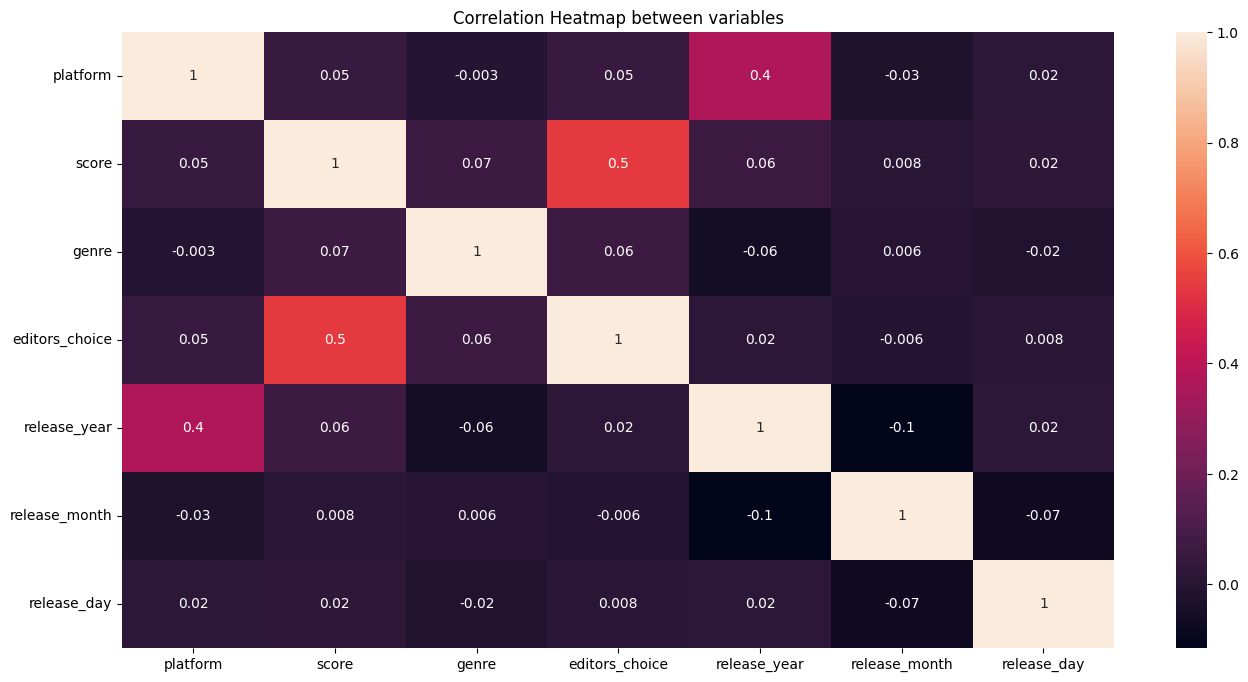

In [140]:
import seaborn as sns

corr_table = opt_games.corr(method = "pearson")

plt.figure(figsize=(16,8))
sns.heatmap(corr_table, annot=True, fmt=".1g")
plt.title("Correlation Heatmap between variables")
plt.show()

Сильно кореллирующих данных нет

Приведем дату к единому числу (можно сказать, что в колонке timestamp будет число, отображающее насколько "старая" игра)

In [141]:
from datetime import date

release_year = opt_games.release_year
release_month = opt_games.release_month
release_day = opt_games.release_day

timestamps = []
for i in range(len(release_year)):
    timestamps.append((date.today() - date(release_year[i], release_month[i], release_day[i])).days)

opt_games = opt_games.drop(["release_year"], axis = 1)
opt_games = opt_games.drop(["release_month"], axis = 1)
opt_games = opt_games.drop(["release_day"], axis = 1)
opt_games['timestamp'] = timestamps

opt_games.head()

,platform,score,genre,editors_choice,timestamp
0,35,9.0,63,1,4498
1,35,9.0,63,1,4498
2,56,8.5,68,0,4498
3,54,8.5,93,0,4499
4,32,8.5,93,0,4499


Разделим датасет и применим GridSearch для поиска гиперпараметров

In [142]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

opt_y_regression = opt_games['score']
opt_X_regression = opt_games.drop(['score'], axis = "columns")

simpleimputer = SimpleImputer(strategy='mean')
opt_X_regression = pd.DataFrame(simpleimputer.fit_transform(opt_X_regression))

opt_X_train_regression, opt_X_test_regression, opt_y_train_regression, opt_y_test_regression = train_test_split(opt_X_regression, opt_y_regression, test_size = 0.1, random_state = 228, shuffle = True)

opt_X_train_regression = scaler.fit_transform(opt_X_train_regression)
opt_X_test_regression = scaler.fit_transform(opt_X_test_regression)


param_grid = {
    'n_estimators': [1, 10, 50],
    'max_depth': [5, 10, None],
    'min_samples_split': [5, 10, 15],
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=228), param_grid, cv=5)
grid_search.fit(opt_X_train_regression, opt_y_train_regression)

print("Лучшие параметры: ", grid_search.best_params_)

Лучшие параметры:  {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}


Oбучение и вывод метрик (также применим масштабирование данных)

MAE: 1.0683192465083282


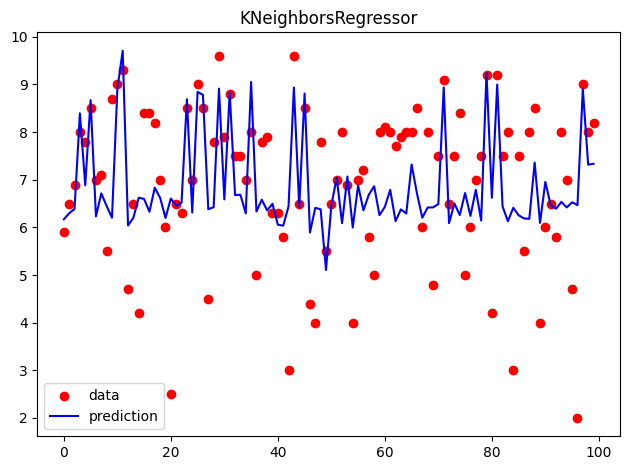

In [180]:
opt_rf_regression = RandomForestRegressor(random_state=228, max_depth=10, n_estimators=50, min_samples_split=5)
opt_rf_model_regression = opt_rf_regression.fit(opt_X_train_regression, opt_y_train_regression)

opt_rf_predictions_regression = opt_rf_regression.predict(opt_X_test_regression)

mae = mean_absolute_error(opt_y_test_regression, opt_rf_predictions_regression)
print(f"MAE: {mae}")

count = 100

plt.scatter(np.arange(0, len(opt_y_test_regression))[0:count], list(opt_y_test_regression)[0:count], color="red", label="data")
plt.plot(np.arange(0, len(opt_y_test_regression))[0:count], opt_rf_predictions_regression[0:count], color="blue", label="prediction")
plt.axis("tight")
plt.legend()
plt.title("KNeighborsRegressor")

plt.tight_layout()
plt.show()


Самостоятельная имплементация

Везде брались те же датасеты


Классификация

In [155]:
import numpy as np
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# да, воспользуемся готовым DecisionTree, делаем же RandomForest
from sklearn.utils import resample


class HandmadeRandomForestClassifier:
    def __init__(self, n_estimators=50, max_depth=None, min_samples_split=5, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.forests = []

    def fit(self, X_train, y_train):
        for _ in range(self.n_estimators):
            X_resampled, y_resampled = resample(X_train, y_train, random_state=228)
            forest = DecisionTreeClassifier(max_depth=self.max_depth,
                                          min_samples_split=self.min_samples_split,
                                          min_samples_leaf=self.min_samples_leaf)
            forest.fit(X_resampled, y_resampled)
            self.forests.append(forest)

    def predict(self, X_test):
        forest_preds = np.array([forest.predict(X_test) for forest in self.forests])
        return np.array([Counter(preds).most_common(1)[0][0] for preds in forest_preds.T])

Обрезка датасета не требуется

In [185]:
tracks_trimmed = tracks

y_classifier = tracks_trimmed['is_popular']
X_classifier = tracks_trimmed.drop(["is_popular", "popularity"], axis = "columns")

print(len(tracks_trimmed[tracks_trimmed['is_popular'] == 1]))

simpleimputer = SimpleImputer(strategy='mean')
X_classifier = pd.DataFrame(simpleimputer.fit_transform(X_classifier))

X_train_classifier, X_test_classifier, y_train_classifier, y_test_classifier = train_test_split(X_classifier, y_classifier, test_size = 0.2, random_state = 228, shuffle = True)

5472


Базовый бейзлайн

accuracy: 0.9398684210526316
f1: 0.3909373611728121
precision: 0.3735144312393888
recall: 0.41006523765144454


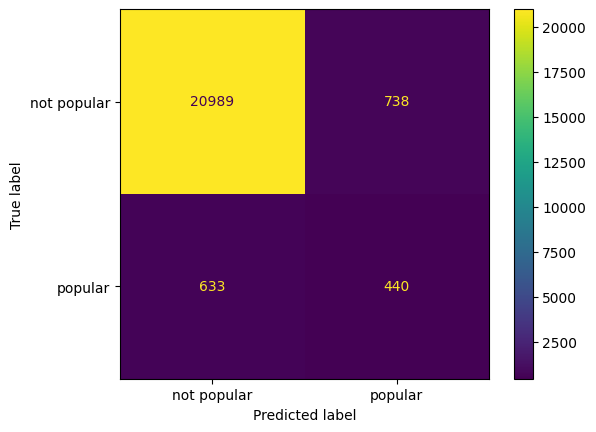

In [186]:
rf_classifier = HandmadeRandomForestClassifier()
rf_model_classifier = rf_classifier.fit(X_train_classifier, y_train_classifier)

rf_predictions_classifier = rf_classifier.predict(X_test_classifier)

accuracy = accuracy_score(y_test_classifier, rf_predictions_classifier)
f1 = f1_score(y_test_classifier, rf_predictions_classifier)
precision = precision_score(y_test_classifier, rf_predictions_classifier)
recall = recall_score(y_test_classifier, rf_predictions_classifier)

print(f"accuracy: {accuracy}")
print(f"f1: {f1}")
print(f"precision: {precision}")
print(f"recall: {recall}")

cm = confusion_matrix(y_test_classifier, rf_predictions_classifier)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks([0, 1], ['not popular', 'popular'])
plt.yticks([0, 1], ['not popular', 'popular'])
plt.show()

In [187]:
opt_tracks_trimmed = opt_tracks

opt_y_classifier = opt_tracks_trimmed['is_popular']
opt_X_classifier = opt_tracks_trimmed.drop(["is_popular", "popularity"], axis = "columns")

print(len(opt_tracks_trimmed[opt_tracks_trimmed['is_popular'] == 1]))

simpleimputer = SimpleImputer(strategy='mean')
opt_X_classifier = pd.DataFrame(simpleimputer.fit_transform(opt_X_classifier))

opt_X_train_classifier, opt_X_test_classifier, opt_y_train_classifier, opt_y_test_classifier = train_test_split(opt_X_classifier, opt_y_classifier, test_size = 0.2, random_state = 228, shuffle = True)

5472


Улучшенный бейзлайн (без кросс-валидации)

accuracy: 0.9375877192982456
f1: 0.34814475492441593
precision: 0.34234234234234234
recall: 0.35414725069897485


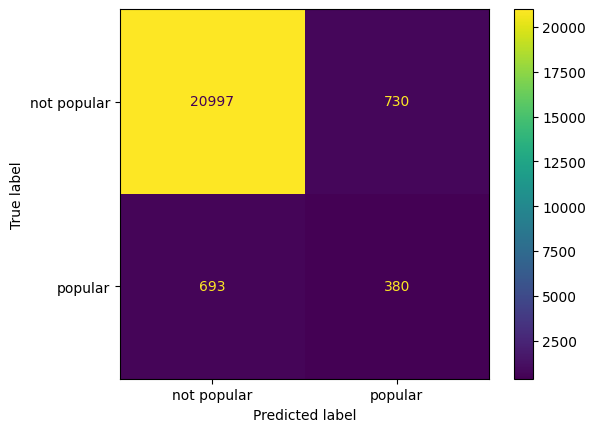

In [188]:
opt_rf_classifier = HandmadeRandomForestClassifier()
opt_rf_model_classifier = opt_rf_classifier.fit(opt_X_train_classifier, opt_y_train_classifier)

opt_rf_predictions_classifier = opt_rf_classifier.predict(opt_X_test_classifier)

accuracy = accuracy_score(opt_y_test_classifier, opt_rf_predictions_classifier)
f1 = f1_score(opt_y_test_classifier, opt_rf_predictions_classifier)
precision = precision_score(opt_y_test_classifier, opt_rf_predictions_classifier)
recall = recall_score(opt_y_test_classifier, opt_rf_predictions_classifier)

print(f"accuracy: {accuracy}")
print(f"f1: {f1}")
print(f"precision: {precision}")
print(f"recall: {recall}")

cm = confusion_matrix(opt_y_test_classifier, opt_rf_predictions_classifier)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks([0, 1], ['not popular', 'popular'])
plt.yticks([0, 1], ['not popular', 'popular'])
plt.show()

Регрессия

In [157]:
import numpy as np
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# да, воспользуемся готовым DecisionTree, делаем же RandomForest
from sklearn.utils import resample

class HandmadeRandomForestRegressor:
    def __init__(self, n_estimators=50, max_depth=None, min_samples_split=5, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.forests = []

    def fit(self, X_train, y_train):
        for _ in range(self.n_estimators):
            X_resampled, y_resampled = resample(X_train, y_train, random_state=228)
            forest = DecisionTreeRegressor(max_depth=self.max_depth,
                                          min_samples_split=self.min_samples_split,
                                          min_samples_leaf=self.min_samples_leaf)
            forest.fit(X_resampled, y_resampled)
            self.forests.append(forest)

    def predict(self, X_test):
        forest_preds = np.array([forest.predict(X_test) for forest in self.forests])
        return np.mean(forest_preds, axis=0)

In [189]:
games_trim = games

y_regression = games_trim['score']
X_regression = games_trim.drop(['score'], axis = "columns")

simpleimputer = SimpleImputer(strategy='mean')
X_regression = pd.DataFrame(simpleimputer.fit_transform(X_regression))

X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X_regression, y_regression, test_size = 0.1, random_state = 228, shuffle = True)

Базовый бейзлайн

MAE: 1.3174609053497943


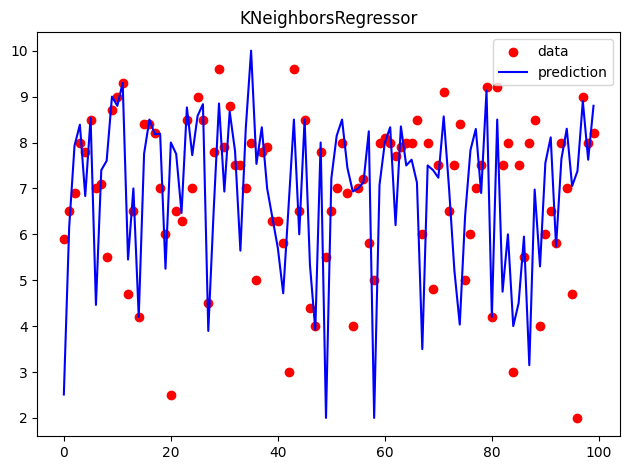

In [190]:
rf_regression = HandmadeRandomForestRegressor()
rf_model_regression = rf_regression.fit(X_train_regression, y_train_regression)

rf_predictions_regression = rf_regression.predict(X_test_regression)

mae = mean_absolute_error(y_test_regression, rf_predictions_regression)
print(f"MAE: {mae}")

count = 100

plt.scatter(np.arange(0, len(y_test_regression))[0:count], list(y_test_regression)[0:count], color="red", label="data")
plt.plot(np.arange(0, len(y_test_regression))[0:count], rf_predictions_regression[0:count], color="blue", label="prediction")
plt.axis("tight")
plt.legend()
plt.title("KNeighborsRegressor")

plt.tight_layout()
plt.show()

Обрезка датасета

In [191]:
scaler = StandardScaler()

opt_games_trim = opt_games

opt_y_regression = opt_games_trim['score']
opt_X_regression = opt_games_trim.drop(['score'], axis = "columns")

simpleimputer = SimpleImputer(strategy='mean')
opt_X_regression = pd.DataFrame(simpleimputer.fit_transform(opt_X_regression))

opt_X_train_regression, opt_X_test_regression, opt_y_train_regression, opt_y_test_regression = train_test_split(opt_X_regression, opt_y_regression, test_size = 0.1, random_state = 228, shuffle = True)

Улучшенный бейзлайн (без кросс-валидации)

MAE: 1.2792922852777926


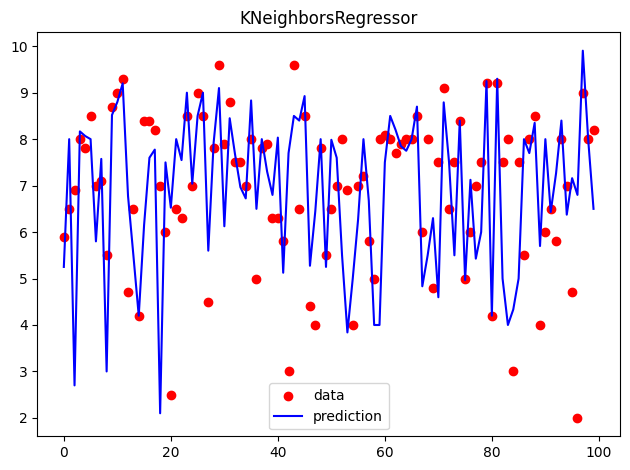

In [193]:
opt_rf_regression = HandmadeRandomForestRegressor()
opt_rf_model_regression = opt_rf_regression.fit(opt_X_train_regression, opt_y_train_regression)

opt_rf_predictions_regression = opt_rf_regression.predict(opt_X_test_regression)

mae = mean_absolute_error(opt_y_test_regression, opt_rf_predictions_regression)
print(f"MAE: {mae}")

count = 100

plt.scatter(np.arange(0, len(opt_y_test_regression))[0:count], list(opt_y_test_regression)[0:count], color="red", label="data")
plt.plot(np.arange(0, len(opt_y_test_regression))[0:count], opt_rf_predictions_regression[0:count], color="blue", label="prediction")
plt.axis("tight")
plt.legend()
plt.title("KNeighborsRegressor")

plt.tight_layout()
plt.show()

Выводы:

1) Случайный лес себя отлично показал в задаче регрессии.

2) Кросс-валидация не смогла получить адекватный recall даже явно указав, по какому параметру идет оптимизация.

3) Собственные имплементации в этот раз работали не так медленно.